In [1]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

## Read in data from GS storage

- `enfo_data`: enformer skew predictions generated using `enformer-usage.ipynb`
- `mpra_data`: MPRA measured skew and BODA model predicted skews
- `enfo_metadata`: enformer output column metadata

In [2]:
enfo_data = pd.read_table('gs://korvaz/mpra_model_manuscript/data/enformer__mpra_test_set_preds.csv', sep='\t', header=0)
mpra_data = pd.read_table('gs://korvaz/mpra_model_manuscript/data/boda2__single_variant_pairs__raw.txt', sep=' ', header=0)

enfo_metadata = pd.read_table('gs://basenji_barnyard/data/human/targets.txt', header=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: DtypeWarning: Columns (10,48) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Filter MPRA measurements

Remove systematically noisy measurements by removing sequences with low oligo counts and near 0 effective activities

In [3]:
plasmid_filter = np.logical_or(
    (mpra_data.loc[:,['ctrl_mean_k562_ref']] >= 100), 
    (mpra_data.loc[:,['ctrl_mean_k562_alt']] >= 100)
).values

activity_filter = np.logical_or(
    (mpra_data.loc[:,['K562_mean_alt']].abs() > 1), 
    (mpra_data.loc[:,['K562_mean_ref']].abs() > 1)
).values

mpra_data = mpra_data.loc[ plasmid_filter & activity_filter ]

In [4]:
enfo_data.columns

Index(['chrom', 'pos', 'id', 'ref', 'alt', '0_DNASE:cerebellum mal',
       '1_DNASE:frontal cortex', '2_DNASE:chorion', '3_DNASE:Ishikawa treat',
       '4_DNASE:GM03348',
       ...
       '5303_CAGE:thalamus, adult', '5304_CAGE:putamen, adult,',
       '5305_CAGE:parietal cortex', '5306_CAGE:medial temporal',
       '5307_CAGE:squamous cell l', '5308_CAGE:epithelioid sar',
       '5309_CAGE:squamous cell l', '5310_CAGE:gastric cancer ',
       '5311_CAGE:carcinoid cell ', '5312_CAGE:lung adenocarci'],
      dtype='object', length=5318)

## Build filters for Enformer predictions
We want K562 related predictions

In [5]:
k562_idxs = [ rec['index'] for i, rec in enfo_metadata.iterrows() if 'K562' in rec['description'] ]
k562_tags = [ tag for tag in enfo_data.columns[5:] if int(tag.split('_')[0]) in k562_idxs ]
k562_flags= [ int(tag.split('_')[0]) in k562_idxs for tag in enfo_data.columns[5:] ]

cage_tags = [ tag for tag in enfo_data.columns if 'CAGE' in tag ]

In [6]:
k562_tags

['33_DNASE:K562 treated w',
 '34_DNASE:K562 G2 phase',
 '35_DNASE:K562 G1 phase',
 '121_DNASE:K562',
 '122_DNASE:K562',
 '123_DNASE:K562',
 '625_DNASE:K562',
 '697_CHIP:CTCF:K562',
 '698_CHIP:H3K27me3:K562',
 '699_CHIP:H3K36me3:K562',
 '700_CHIP:H3K4me2:K562',
 '701_CHIP:H3K4me3:K562',
 '702_CHIP:H3K9ac:K562',
 '703_CHIP:H3K9me1:K562',
 '760_CHIP:H2AFZ:K562',
 '761_CHIP:H3K79me2:K562',
 '762_CHIP:H3K9me3:K562',
 '774_CHIP:KDM5B:K562',
 '776_CHIP:HDAC1:K562',
 '777_CHIP:HDAC2:K562',
 '778_CHIP:PHF8:K562',
 '779_CHIP:RBBP5:K562',
 '780_CHIP:SAP30:K562',
 '834_CHIP:HDAC6:K562',
 '841_CHIP:CREBBP:K562',
 '842_CHIP:CBX3:K562',
 '843_CHIP:KAT2B:K562',
 '844_CHIP:SIRT6:K562',
 '845_CHIP:SUZ12:K562',
 '856_CHIP:SETDB1:K562',
 '863_CHIP:WHSC1:K562',
 '946_CHIP:BCLAF1:K562',
 '951_CHIP:ETS1:K562',
 '952_CHIP:POLR2AphosphoS5',
 '958_CHIP:E2F6:K562',
 '960_CHIP:GABPA:K562',
 '961_CHIP:MAX:K562',
 '962_CHIP:SIN3A:K562',
 '971_CHIP:ZBTB7A:K562',
 '973_CHIP:YY1:K562',
 '979_CHIP:POLR2A:K562',
 '981_C

In [7]:
cage_tags

['4675_CAGE:Clontech Human ',
 '4676_CAGE:SABiosciences X',
 '4677_CAGE:Universal RNA -',
 '4678_CAGE:adipose tissue,',
 '4679_CAGE:bladder, adult,',
 '4680_CAGE:brain, adult, p',
 '4681_CAGE:cervix, adult, ',
 '4682_CAGE:colon, adult, p',
 '4683_CAGE:esophagus, adul',
 '4684_CAGE:heart, adult, p',
 '4685_CAGE:kidney, adult, ',
 '4686_CAGE:liver, adult, p',
 '4687_CAGE:lung, adult, po',
 '4688_CAGE:ovary, adult, p',
 '4689_CAGE:placenta, adult',
 '4690_CAGE:prostate, adult',
 '4691_CAGE:skeletal muscle',
 '4692_CAGE:small intestine',
 '4693_CAGE:spleen, adult, ',
 '4694_CAGE:testis, adult, ',
 '4695_CAGE:thymus, adult, ',
 '4696_CAGE:thyroid, adult,',
 '4697_CAGE:trachea, adult,',
 '4698_CAGE:retina, adult, ',
 '4699_CAGE:temporal lobe, ',
 '4700_CAGE:postcentral gyr',
 '4701_CAGE:pons, adult, po',
 '4702_CAGE:parietal lobe, ',
 '4703_CAGE:paracentral gyr',
 '4704_CAGE:occipital pole,',
 '4705_CAGE:nucleus accumbe',
 '4706_CAGE:medulla oblonga',
 '4707_CAGE:insula, adult, ',
 '4708_CAG

## Refine K562 features
Based on the paper, use DNase and CAGE preds for VEP, and summarize using the first dim from PCA

In [8]:
strict_k562_filter = k562_tags[0:7] + k562_tags[-2:] 

In [9]:
pca = PCA(n_components=2)
enfo_pca = pca.fit_transform(enfo_data.loc[:, strict_k562_filter])
for dim in range(enfo_pca.shape[1]):
    enfo_data[f'PC_{dim}'] = enfo_pca[:,dim]
    
if pearsonr( enfo_data.loc[:, strict_k562_filter].mean(axis=1), enfo_data.loc[:, 'PC_0'] )[0] >= 0:
    pass
else:
    enfo_data.loc[:, 'PC_0'] = enfo_data.loc[:, 'PC_0'] * -1

In [10]:
full_filter = list(enfo_data.columns[0:5]) + list(strict_k562_filter) + [f'PC_{dim}' for dim in range(enfo_pca.shape[1])]
k562_dnase_flags = [ tag in full_filter for tag in enfo_data.columns ]

In [11]:
full_filter

['chrom',
 'pos',
 'id',
 'ref',
 'alt',
 '33_DNASE:K562 treated w',
 '34_DNASE:K562 G2 phase',
 '35_DNASE:K562 G1 phase',
 '121_DNASE:K562',
 '122_DNASE:K562',
 '123_DNASE:K562',
 '625_DNASE:K562',
 '4828_CAGE:chronic myeloge',
 '5111_CAGE:chronic myeloge',
 'PC_0',
 'PC_1']

## Merge Enformer predictions with MPRA measurements \/ BODA predictions

In [12]:
merged_data = pd.concat(
    [
        enfo_data.loc[:, k562_dnase_flags].set_index('id'), 
        mpra_data.loc[:,['IDs_ref','K562_mean_alt','K562_mean_ref','K562_pred_aggreg_alt','K562_pred_aggreg_ref']].set_index('IDs_ref')
    ],axis=1,join='inner'
)

In [13]:
merged_data

,chrom,pos,ref,alt,33_DNASE:K562 treated w,34_DNASE:K562 G2 phase,35_DNASE:K562 G1 phase,121_DNASE:K562,122_DNASE:K562,123_DNASE:K562,625_DNASE:K562,4828_CAGE:chronic myeloge,5111_CAGE:chronic myeloge,PC_0,PC_1,K562_mean_alt,K562_mean_ref,K562_pred_aggreg_alt,K562_pred_aggreg_ref
13:100002396:G:A:R:wC,chr13,100002396,G,A,-2.555246,-2.420064,-2.302054,-2.110521,-2.198323,-1.209785,-3.282127,0.442445,0.816094,0.331491,4.518724,2.781675,2.697974,2.211418,2.224014
13:100011671:A:T:R:wC,chr13,100011671,A,T,-1.168738,-1.210103,-1.138374,-1.868320,-0.950654,-3.566528,-2.025913,-2.145049,-1.516973,-2.807367,2.960850,0.089741,-1.523238,0.095899,0.087643
13:100018882:AT:A:R:wC,chr13,100018882,AT,A,-4.388731,-47.530415,-43.018353,3.191714,27.550501,21.457153,-40.955158,-116.002403,-98.335190,-148.460146,-18.450737,1.106618,1.091794,0.315574,0.309365
13:100029932:C:T:R:wC,chr13,100029932,C,T,0.044262,0.233256,0.081109,-1.814088,-0.647156,-2.148091,-1.255593,-0.524880,-0.718360,-0.801606,1.381093,2.548865,2.492148,0.884519,0.875409
13:100034775:A:G:R:wC,chr13,100034775,A,G,-3.219236,-1.828756,-2.027370,-1.105868,-3.049481,1.048982,-3.286332,8.826091,5.916554,9.496334,5.465983,1.496568,1.461471,1.070647,1.097058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7:99962298:A:G:R:wC,chr7,99962298,A,G,11.050347,9.025737,9.292895,2.425585,1.454478,8.550963,4.623303,-53.950325,-75.670097,-86.787299,-35.728690,2.328062,1.724010,2.423404,2.265055
7:99964789:T:G:R:wC,chr7,99964789,T,G,-22.641222,-16.945456,-17.594418,-33.957935,-30.110519,-33.145550,-62.727489,7.017664,-14.991410,-26.722103,83.705961,3.321654,3.112151,2.257640,2.004113
7:99977582:T:G:R:wC,chr7,99977582,T,G,0.235380,2.444194,2.828433,1.014659,-4.103906,-2.158255,5.401651,19.882153,26.469482,33.476117,4.349000,2.208010,1.957722,0.912985,0.943092
7:99980104:T:C:R:wC,chr7,99980104,T,C,44.459644,40.970562,37.157715,83.581902,63.895691,70.162918,121.673676,144.461349,250.415741,322.332510,-120.640081,4.166115,4.238000,3.899991,3.664589


## Plot skew: predictions (y axis) vs MPRA measured (x axis)

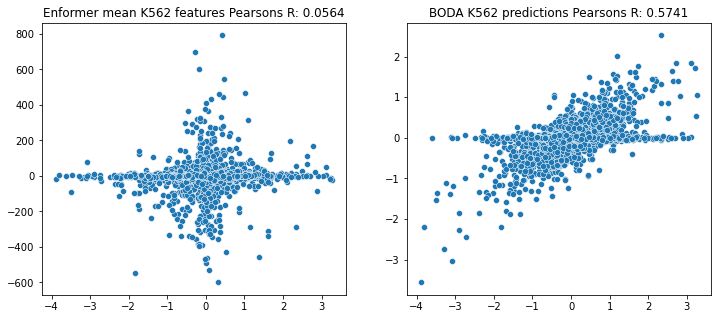

In [14]:
fig, axes = plt.subplots(1,2, figsize=[12,5])

enfo_corr = pearsonr(
    merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    merged_data.loc[:,strict_k562_filter].mean(axis=1)
)

mpra_corr = pearsonr(
    merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref']
)


sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y=merged_data.loc[:,strict_k562_filter].mean(axis=1),
    ax=axes[0]
)

sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y=merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref'],
    ax=axes[1]
)

axes[0].title.set_text(f'Enformer mean K562 features Pearsons R: {enfo_corr[0]:.4f}')
axes[1].title.set_text(f'BODA K562 predictions Pearsons R: {mpra_corr[0]:.4f}')


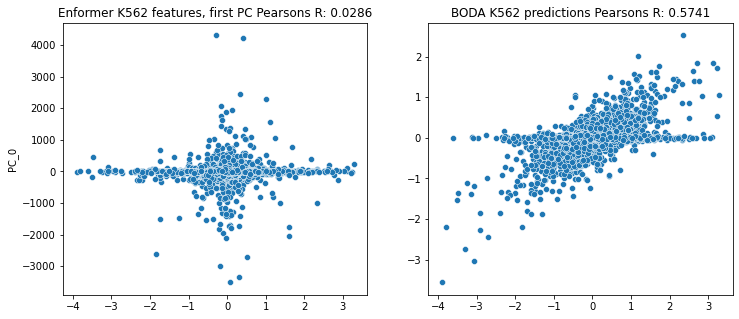

In [15]:
fig, axes = plt.subplots(1,2, figsize=[12,5])

enfo_corr = pearsonr(
    merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    merged_data.loc[:,'PC_0']
)

mpra_corr = pearsonr(
    merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref']
)


sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y=merged_data.loc[:,'PC_0'],
    ax=axes[0]
)

sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y=merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref'],
    ax=axes[1]
)

axes[0].title.set_text(f'Enformer K562 features, first PC Pearsons R: {enfo_corr[0]:.4f}')
axes[1].title.set_text(f'BODA K562 predictions Pearsons R: {mpra_corr[0]:.4f}')